In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
from os.path import join
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from scipy.stats import pearsonr
from IPython.display import display
from skopt.plots import plot_objective
import seaborn as sns
from time import time
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import xgboost as xgb

rng_seed = 399
np.random.seed(rng_seed)
import persim
import joblib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    f1_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV
from sklearn.preprocessing import minmax_scale, RobustScaler

import tensorflow as tf

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], "GPU")
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != "GPU"
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Directory constants
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from topological_data_analysis.topological_polysemy import tps
from word_embeddings.word2vec import load_model_training_output
from analysis_of_embeddings.estimate_num_meanings_supervised import (
    create_classification_labels,
    evaluate_regression_model,
    evaluate_classification_model,
    create_feature_importance_df,
    visualize_feature_importances
)

## Prepare data

In [2]:
word_meaning_train_data = pd.read_csv("data/word_meaning_train_data.csv")
word_meaning_test_data = pd.read_csv("data/word_meaning_test_data.csv")
word_meaning_semeval_test_data = pd.read_csv("data/word_meaning_semeval_test_data.csv")
word_meaning_data_cols = word_meaning_train_data.columns.values
word_meaning_data_feature_cols = np.array(
    [col for col in word_meaning_data_cols if col.startswith("X_")]
)

In [3]:
print("Train")
word_meaning_train_data

Train


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_50_250_P_int,X_gad_knn_50_550_P_bnd,X_gad_knn_50_550_P_man,X_gad_knn_50_550_P_int,X_gad_knn_50_750_P_bnd,X_gad_knn_50_750_P_man,X_gad_knn_50_750_P_int,X_gad_knn_100_1000_P_bnd,X_gad_knn_100_1000_P_man,X_gad_knn_100_1000_P_int
0,in,7,4.248133,1.046609,0.523305,0.523305,8.200863,1.022337,0.511169,0.511169,...,0,1,0,0,1,0,0,1,0,0
1,a,7,3.850081,1.026458,0.513229,0.513229,7.565535,1.022583,0.511291,0.511291,...,0,1,0,0,1,0,0,1,0,0
2,thousand,2,3.770527,1.035653,0.517826,0.517826,7.150504,1.003230,0.501615,0.501615,...,0,1,0,0,1,0,0,1,0,0
3,one,9,2.174424,0.732104,0.366052,0.366052,4.876410,0.860300,0.430150,0.430150,...,0,1,0,0,1,0,0,1,0,0
4,hundred,2,4.093440,1.042251,0.521126,0.521126,8.360992,1.045908,0.522954,0.522954,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137093,kichais,1,3.750899,0.990532,0.495266,0.495266,7.905969,0.945381,0.472691,0.472691,...,0,1,0,0,1,0,0,1,0,0
137094,hassams,1,4.690177,1.096302,0.548151,0.548151,9.694982,1.109408,0.554704,0.554704,...,0,1,0,0,1,0,0,1,0,0
137095,bisters,1,4.543681,1.060358,0.530179,0.530179,8.981394,1.036390,0.518195,0.518195,...,0,1,0,0,1,0,0,1,0,0
137096,obstructor,2,4.324607,1.028723,0.514361,0.514361,8.734713,1.024522,0.512261,0.512261,...,0,1,0,0,1,0,0,1,0,0


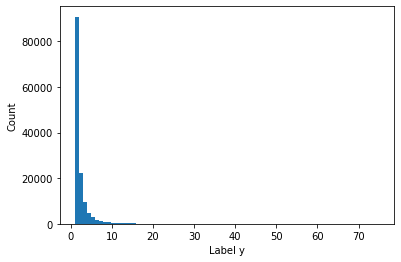

In [4]:
plt.hist(word_meaning_train_data["y"], bins=word_meaning_train_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [5]:
print("Test")
word_meaning_test_data

Test


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_50_250_P_int,X_gad_knn_50_550_P_bnd,X_gad_knn_50_550_P_man,X_gad_knn_50_550_P_int,X_gad_knn_50_750_P_bnd,X_gad_knn_50_750_P_man,X_gad_knn_50_750_P_int,X_gad_knn_100_1000_P_bnd,X_gad_knn_100_1000_P_man,X_gad_knn_100_1000_P_int
0,as,10,4.317206,1.077280,0.538640,0.538640,8.057132,1.077280,0.538640,0.538640,...,0,1,0,0,1,0,0,1,0,0
1,eight,4,4.294665,1.093943,0.546971,0.546971,8.501568,1.037538,0.518769,0.518769,...,0,1,0,0,1,0,0,1,0,0
2,time,15,3.427256,0.885813,0.442906,0.442906,6.465290,0.885813,0.442906,0.442906,...,0,1,0,0,1,0,0,1,0,0
3,under,10,4.190029,1.127449,0.563724,0.563724,8.322828,1.012981,0.506491,0.506491,...,0,1,0,0,1,0,0,1,0,0
4,well,22,3.179627,0.774289,0.387145,0.387145,6.710519,0.740595,0.370297,0.370297,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,effs,1,4.354566,1.004452,0.502226,0.502226,8.303034,1.004085,0.502042,0.502042,...,0,1,0,0,1,0,0,1,0,0
7212,pushful,1,4.256451,1.005711,0.502855,0.502855,8.527463,0.969283,0.484641,0.484641,...,0,1,0,0,1,0,0,1,0,0
7213,coapted,2,4.131102,0.962983,0.481492,0.481492,8.338664,0.965748,0.482874,0.482874,...,0,1,0,0,1,0,0,1,0,0
7214,troponyms,1,4.151853,1.018178,0.509089,0.509089,8.882389,1.034668,0.517334,0.517334,...,0,1,0,0,1,0,0,1,0,0


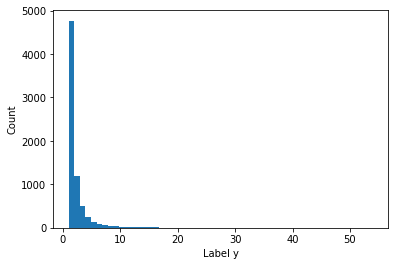

In [6]:
plt.hist(word_meaning_test_data["y"], bins=word_meaning_test_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [7]:
# Split into X and y
X_train = minmax_scale(word_meaning_train_data[word_meaning_data_feature_cols].values)
X_test = minmax_scale(word_meaning_test_data[word_meaning_data_feature_cols].values)
X_test_semeval = minmax_scale(
    word_meaning_semeval_test_data[word_meaning_data_feature_cols].values
)
y_train = word_meaning_train_data["y"].values
y_test = word_meaning_test_data["y"].values
y_test_semeval = word_meaning_semeval_test_data["y"].values

In [8]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
)
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

In [9]:
# Load SemEval-2010 task 14 words
semeval_2010_14_word_senses = joblib.load(
    join(
        "..", "topological_data_analysis", "data", "semeval_2010_14_word_senses.joblib"
    )
)
semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_target_words_in_vocab_filter = [
    i for i, word in enumerate(semeval_target_words) if word in word_to_int
]
semeval_target_words_in_vocab = semeval_target_words[
    semeval_target_words_in_vocab_filter
]
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))
semeval_gs_clusters_in_vocab = semeval_gs_clusters[semeval_target_words_in_vocab_filter]

num_semeval_words = len(semeval_target_words_in_vocab)

## Do modeling

In [10]:
xbg_cv = joblib.load("data/estimate_num_meanings_supervised/xgb_reg_old.joblib")
xbg_cv.best_params_

OrderedDict([('alpha', 0.5048003662777794), ('eta', 0.020339002426162933)])

array([[<AxesSubplot:xlabel='alpha', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='alpha', ylabel='eta'>,
        <AxesSubplot:xlabel='eta', ylabel='Partial dependence'>]],
      dtype=object)

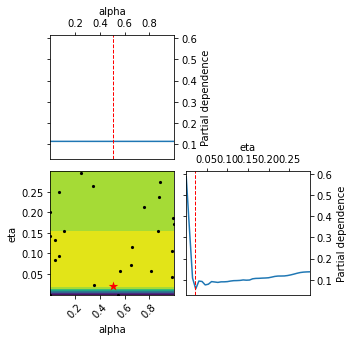

In [11]:
plot_objective(xbg_cv.optimizer_results_[0])

In [12]:
model = xbg_cv.best_estimator_

In [13]:
model.score(X_train, y_train)

0.15111508462890322

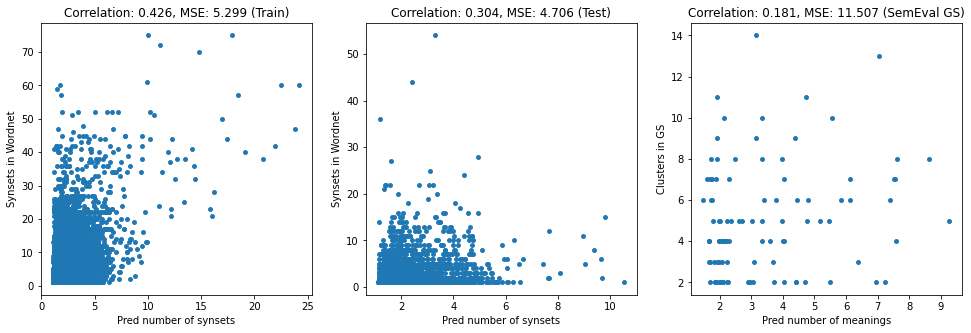

In [14]:
evaluate_regression_model(
    model=model,
    test_sets=[
        (X_train, y_train, "Train", "Pred number of synsets", "Synsets in Wordnet"),
        (X_test, y_test, "Test", "Pred number of synsets", "Synsets in Wordnet"),
        (
            X_test_semeval,
            y_test_semeval,
            "SemEval GS",
            "Pred number of meanings",
            "Clusters in GS",
        ),
    ],
)

In [20]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols, feature_importances=model.feature_importances_
    )
)

,feature,importance
0,X_estimated_id_twonn,0.12789637
1,X_tps_100,0.09193407
2,X_tps_10_pd_max,0.07459682
3,X_tps_80,0.05173572
4,X_tps_30,0.03921581
5,X_tps_90,0.038172692
6,X_tps_40_pd_max,0.037513226
7,X_tps_20_pd_max,0.03641251
8,X_tps_20,0.036188196
9,X_tps_50_pd_max,0.030340498


### Lasso regression with K-fold CV

In [21]:
# Load training result
lasso_cv = joblib.load("data/estimate_num_meanings_supervised/lasso_reg.joblib")
print(f"Selected alpha: {lasso_cv.alpha_}")

Selected alpha: 0.0001


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LassoCV from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols, feature_importances=np.abs(lasso_cv.coef_)
    )
)

,feature,importance
0,X_tps_90,3.715177447354156
1,X_estimated_id_twonn,2.3200282375909853
2,X_tps_70,2.007045438027298
3,X_estimated_id_mle,1.8746762317703958
4,X_tps_10_pd_max,1.765933476101751
5,X_tps_40,1.5060780208982507
6,X_estimated_id_lpca,1.378125729309843
7,X_tps_20_pd_max,0.9303959734820489
8,X_tps_10,0.7761041531512662
9,X_tps_90_pd_max,0.7011021638748473


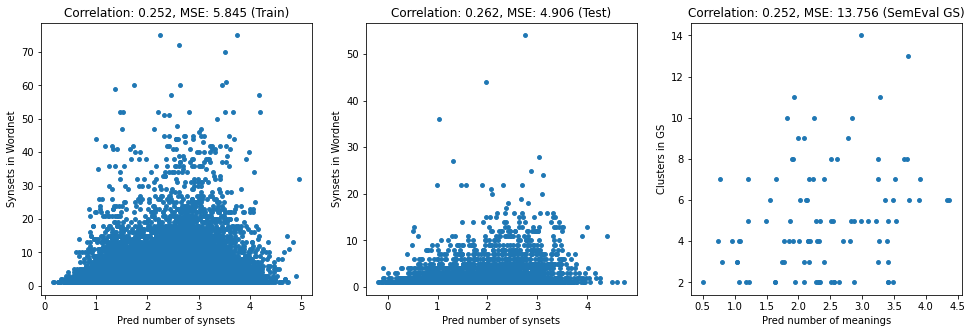

In [24]:
evaluate_regression_model(
    model=lasso_cv,
    test_sets=[
        (X_train, y_train, "Train", "Pred number of synsets", "Synsets in Wordnet"),
        (X_test, y_test, "Test", "Pred number of synsets", "Synsets in Wordnet"),
        (
            X_test_semeval,
            y_test_semeval,
            "SemEval GS",
            "Pred number of meanings",
            "Clusters in GS",
        ),
    ],
)

### Multi-class logistic regression with L1-penalty, finding optimal alpha with K-fold CV

In [25]:
# Create multi-class labels
max_y_multi = np.quantile(y_train, q=0.9)
y_train_multi_class = create_classification_labels(
    labels=y_train, max_label=max_y_multi
)
y_test_multi_class = create_classification_labels(labels=y_test, max_label=max_y_multi)
y_test_semeval_multi_class = create_classification_labels(
    labels=y_test_semeval, max_label=max_y_multi
)

In [26]:
# Load result from training
log_reg_cv = joblib.load(
    "data/estimate_num_meanings_supervised/multi_class_logistic_reg.joblib"
)
alphas = 1 / log_reg_cv.C_
print(f"Selected alphas: {alphas}")

Selected alphas: [0.08127813 0.08127813 0.08127813 0.08127813 0.08127813]


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [27]:
labels_str = [
    str(label + 1) if i < 4 else "gt_or_eq_5"
    for i, label in enumerate(log_reg_cv.classes_)
]

In [28]:
df_dict = {}
for label_str, coeffs in zip(labels_str, log_reg_cv.coef_):
    sorted_feature_weights_indices = np.argsort(np.abs(coeffs))[::-1]
    df_dict[f"feature_{label_str}"] = word_meaning_data_feature_cols[
        sorted_feature_weights_indices
    ]
    df_dict[f"weight_{label_str}"] = coeffs[sorted_feature_weights_indices]

sorted_features_df = pd.DataFrame(df_dict)
visualize_feature_importances(feature_importances=sorted_features_df)

,feature_1,weight_1,feature_2,weight_2,feature_3,weight_3,feature_4,weight_4,feature_gt_or_eq_5,weight_gt_or_eq_5
0,X_tps_90,5.483908,X_tps_100,2.185979e+00,X_tps_70,-2.582598,X_tps_50,3.058629,X_tps_60,-3.016208
1,X_estimated_id_mle,-3.064712,X_tps_90,1.452512e+00,X_tps_60,1.893363,X_tps_70,-2.250088,X_estimated_id_twonn,-2.661173
2,X_estimated_id_twonn,1.824396,X_tps_80,-1.269355e+00,X_tps_80,1.518900,X_tps_60,-2.213706,X_tps_40,1.521031
3,X_tps_40,-1.664799,X_tps_40,-1.092723e+00,X_tps_50,-0.773635,X_estimated_id_twonn,-0.950775,X_tps_90,-1.236191
4,X_estimated_id_lpca,-1.562936,X_estimated_id_twonn,1.064382e+00,X_tps_20,0.698459,X_tps_80,0.908643,X_tps_30,0.971987
5,X_tps_70,1.466333,X_estimated_id_mle,-8.276505e-01,X_tps_90,-0.543088,X_tps_30,-0.747436,X_tps_50,0.873222
6,X_tps_80,-1.035988,X_gad_knn_25_500_P_man,7.751104e-01,X_tps_30,-0.542539,X_estimated_id_mle,0.509994,X_estimated_id_mle,0.738282
7,X_tps_100,0.960664,X_gad_knn_25_250_P_man,7.751104e-01,X_tps_40,0.453907,X_tps_40_pd_std,0.363469,X_tps_100,-0.684237
8,X_tps_20,-0.596228,X_estimated_id_lpca,-7.556746e-01,X_tps_80_pd_avg,-0.244154,X_tps_40_pd_avg,0.363469,X_estimated_id_lpca,0.636306
9,X_tps_10,-0.443040,X_tps_30,6.174733e-01,X_tps_80_pd_std,-0.244154,X_tps_40_pd_max,0.363469,X_tps_10_pd_avg,0.422329


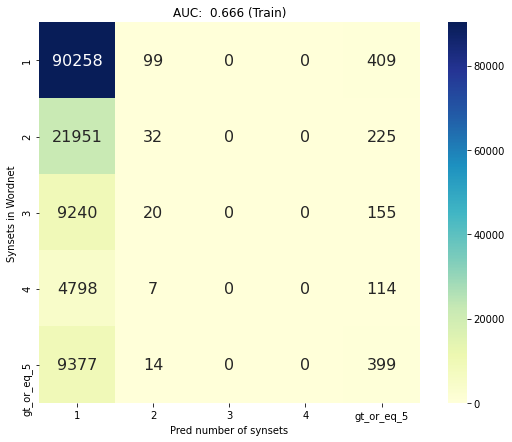

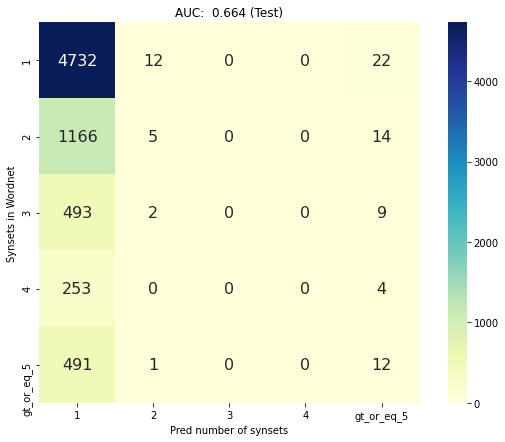

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [29]:
evaluate_classification_model(
    model=log_reg_cv,
    test_sets=[
        (
            X_train,
            y_train_multi_class,
            "Train",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
        (
            X_test,
            y_test_multi_class,
            "Test",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
        (
            X_test_semeval,
            y_test_semeval_multi_class,
            "SemEval GS",
            "Pred number of meanings",
            "Clusters in GS",
        ),
    ],
    cm_ticklabels=labels_str,
)